# Cup04: Unlearnable Dataset
110065508 李丞恩

model資料夾裡面的ResNet50_cup04有90％！！！不要洗掉喔！！！

In [1]:
INPUT_SHAPE = (224, 224, 3)
BATCH_SIZE = 64 
EPOCHS = 100
PATIENCE = 10 # 如果過多少個EPOCHS沒改善就停止訓練
CATGORICAL = 2
LR = 0.001
LR_FACTOR = 0.5 # new_lr = lr * factor.
LR_PATIENCE = 4 # umber of epochs with no improvement after which learning rate will be reduced
MODEL_NAME = 'ResNet50_cup04_imagenet'
MODEL_PATH = './model/' + MODEL_NAME + '.hdf5'

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

import os
import re
import PIL
import time
import random
import string
import datetime
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from pathlib import Path
from IPython import display
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score
from sklearn.model_selection import learning_curve

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Dropout, Flatten, Dense
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Restrict TensorFlow to only use the first GPU
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')

        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [4]:
AUTO = tf.data.AUTOTUNE

## 一. 引入Dataset

In [5]:
x_train = np.load('./dataset/x_train_imagenet_unlearn.npy')
y_train = np.load('./dataset/y_train_imagenet.npy')
x_val = np.load('./dataset/x_val_imagenet.npy')
y_val = np.load('./dataset/y_val_imagenet.npy')
y_train = np.argmax(y_train, axis=1)
y_val = np.argmax(y_val, axis=1)

## 二. 資料前處理

In [6]:
def mixup(images, labels):
    alpha = tf.random.uniform([], 0, 1)
    mixedup_images = (alpha * images +
                     (1 - alpha) * tf.reverse(images, axis=[0]))
    return mixedup_images, labels

In [7]:
def mixup_dataset(dataset):
    mixup_ds = dataset.map(mixup, num_parallel_calls=AUTO)
    dataset = dataset.concatenate(mixup_ds)
    dataset = dataset.shuffle(BATCH_SIZE*10)
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
    return dataset

In [8]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
batched_dataset = mixup_dataset(train_dataset)
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
batched_val_dataset = mixup_dataset(val_dataset)

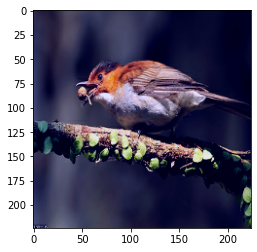

In [9]:
for data in batched_dataset.take(1):
    plt.imshow(data[0][3],cmap='gray')

In [10]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.Rescaling(scale=1/255),
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical", input_shape=INPUT_SHAPE),
    layers.experimental.preprocessing.RandomContrast(factor = 0.5),
    layers.experimental.preprocessing.Normalization()
])

## 三. 模型搭建

In [11]:
model = Sequential([
    data_augmentation,
    ResNet50(include_top=False, weights=None, input_tensor=None, input_shape=INPUT_SHAPE), 
    Flatten(),
    Dropout(0.5),
    Dense(CATGORICAL, activation='softmax', name='softmax')
],
    name=MODEL_NAME
)
model.build((None, INPUT_SHAPE[0], INPUT_SHAPE[1], INPUT_SHAPE[2]))
model.summary()

Model: "ResNet50_cup04_imagenet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 224, 224, 3)       7         
_________________________________________________________________
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
flatten (Flatten)            (None, 100352)            0         
_________________________________________________________________
dropout (Dropout)            (None, 100352)            0         
_________________________________________________________________
softmax (Dense)              (None, 2)                 200706    
Total params: 23,788,425
Trainable params: 23,735,298
Non-trainable params: 53,127
_________________________________________________________________


In [12]:
loss_fn = tf.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.optimizers.Adam(learning_rate=LR)
model.compile(optimizer=optimizer, loss=loss_fn, metrics=['acc'])

## 四. 模型訓練

In [13]:
checkpoint = ModelCheckpoint(filepath=MODEL_PATH, 
                             monitor='val_acc',
                             verbose=1, 
                             save_best_only=True, 
                             mode='auto', 
                             save_weights_only = True)
reduceLROnPlat = ReduceLROnPlateau(monitor='val_acc', 
                                   factor=LR_FACTOR, 
                                   patience=LR_PATIENCE, 
                                   verbose=1, 
                                   mode='auto', 
                                   min_delta=0.0001)
early = EarlyStopping(monitor='val_acc', 
                      mode="auto", 
                      patience=PATIENCE)
callbacks_list = [checkpoint, reduceLROnPlat, early]

In [14]:
start = datetime.datetime.now()
history = model.fit(x=batched_dataset, 
                    validation_data=batched_val_dataset, 
                    epochs=EPOCHS,
                    callbacks=callbacks_list,
                    verbose=1)
end = datetime.datetime.now()
CNN_time = end - start

Epoch 1/100


C:\Users\acer\anaconda3\envs\tf\lib\site-packages\tensorflow\python\keras\backend.py:4929: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  warnings.warn(


ResourceExhaustedError:  OOM when allocating tensor with shape[64,256,56,56] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node ResNet50_cup04_imagenet/resnet50/conv2_block1_0_conv/Conv2D (defined at \AppData\Local\Temp/ipykernel_20512/1841719173.py:2) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_train_function_12874]

Function call stack:
train_function


## 五. 繪製結果

In [ ]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
epoch = len(history.history['acc'])
train_acc = np.max(history.history['acc'])
val_acc = np.max(history.history['val_acc'])

In [ ]:
localtime = time.strftime("%Y-%m-%d %I:%M:%S %p", time.localtime())
with open('./output/result_imagenet.txt',  'a') as file_obj:
    file_obj.write('================RUN TIME: '+ localtime+ '================' + '\n')
    file_obj.write('model_name: '    + str(MODEL_NAME)        + '\n')
    file_obj.write('epoch: '         + str(epoch)             + '\n')
    file_obj.write('training time: ' + str(CNN_time)          + '\n')
    file_obj.write('train_acc: '     + str(train_acc)     + '\n')
    file_obj.write('val_acc: '       + str(val_acc)       + '\n')

## 六. 繳交

In [ ]:
model.load_weights(MODEL_PATH)

In [ ]:
x_test = np.load('./dataset/x_test_imagenet.npy')

In [ ]:
y_test = np.argmax(model.predict(x_test, batch_size=BATCH_SIZE, verbose=1), axis=1).tolist()

Make submit file

In [ ]:
id_csv = [i for i in range(len(y_test))]
df = pd.DataFrame(list(zip(id_csv,y_test)), columns = ['id','label'])
df.to_csv('./output/cup04_imagenet_group2.csv', index=False)